In [262]:
import torch
from torch import optim, nn

from torchvision import datasets, models
from torchvision.transforms import ToTensor, Resize, Compose
from torch.utils.data import Dataset, DataLoader, Subset

from torchinfo import summary

import matplotlib.pyplot as plt
plt.rcParams['axes.grid'] = True

from tqdm import tqdm

In [205]:
Transfrom = Compose([ToTensor(), Resize(224)])

In [207]:
train_data = datasets.CIFAR100(
    root="data",
    train=True,
    download=True,
    transform=Transfrom,
    )

Files already downloaded and verified


In [208]:
test_val_data = datasets.CIFAR100(
    root="data",
    train=False,
    download=True,
    transform=Transfrom,
    )

val_data, test_data = torch.utils.data.random_split(test_val_data, [5000, 5000])

Files already downloaded and verified


In [210]:
len(train_data), len(val_data), len(test_data)

(50000, 5000, 5000)

Text(0.5, 1.0, 'Target = 19')

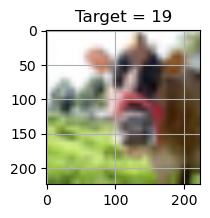

In [128]:
plt.figure(figsize=(2,2))
plt.imshow(train_data[0][0].permute(1, 2, 0))
plt.title("Target = " +str(train_data[0][1]))

In [249]:
image_shape = train_data[0][0].shape
image_shape = (1,) + tuple(image_shape)
image_shape

(1, 3, 224, 224)

I divide the labels in NUM_TASKS sets, each containing SET_SIZE labels. The sets are disjoint.

In [221]:
num_tasks = 10
set_size = 100 // num_tasks

Target separators define by simple inequality which set does a label belong to.

In [132]:
target_sep = [(i*set_size, (i+1)*set_size) for i in range(num_tasks)]

In [133]:
target_sep

[(0, 10),
 (10, 20),
 (20, 30),
 (30, 40),
 (40, 50),
 (50, 60),
 (60, 70),
 (70, 80),
 (80, 90),
 (90, 100)]

Training process:
stepwise learning on each of the sets. The labels in each training session are new for the model. 
The accuracy is measured on the test data with labels from set 0 after each training session.

In [218]:
def make_dataloaders(dataset, batch_size=32):
    loaders = [None for _ in range(num_tasks)]
    for i, separator in tqdm(enumerate(target_sep)):
        indx = [j for j, (_, target) in enumerate(dataset) if separator[0] <= target < separator[1]]
        subset = Subset(dataset, indx)
        loaders[i] = DataLoader(subset, batch_size=batch_size,
                                   shuffle=True, num_workers=1)
    return loaders

In [219]:
train_loaders = make_dataloaders(train_data)
val_loaders = make_dataloaders(val_data)
test_loaders = make_dataloaders(test_data)

10it [02:08, 12.83s/it]
10it [00:12,  1.29s/it]
10it [00:12,  1.28s/it]


In [222]:
for i in train_loaders[0]:
    print(i[0].shape, i[1].shape)
    print(i[1])
    break

torch.Size([32, 3, 224, 224]) torch.Size([32])
tensor([1, 4, 3, 5, 6, 9, 0, 9, 6, 7, 8, 7, 4, 6, 9, 2, 0, 1, 2, 1, 6, 0, 6, 3,
        9, 6, 2, 5, 1, 7, 2, 1])


Select a model

In [138]:
from torch import device
device = device("cuda")

In [179]:
model = nn.Sequential(models.resnet18(), 
                      nn.ReLU(), 
                      nn.Linear(1000, 100),
                      nn.LogSoftmax(dim=1)
                      )
model.to(device)
summary(model, (1, 3, 32, 32))

Layer (type:depth-idx)                        Output Shape              Param #
Sequential                                    [1, 100]                  --
├─ResNet: 1-1                                 [1, 1000]                 --
│    └─Conv2d: 2-1                            [1, 64, 16, 16]           9,408
│    └─BatchNorm2d: 2-2                       [1, 64, 16, 16]           128
│    └─ReLU: 2-3                              [1, 64, 16, 16]           --
│    └─MaxPool2d: 2-4                         [1, 64, 8, 8]             --
│    └─Sequential: 2-5                        [1, 64, 8, 8]             --
│    │    └─BasicBlock: 3-1                   [1, 64, 8, 8]             73,984
│    │    └─BasicBlock: 3-2                   [1, 64, 8, 8]             73,984
│    └─Sequential: 2-6                        [1, 128, 4, 4]            --
│    │    └─BasicBlock: 3-3                   [1, 128, 4, 4]            230,144
│    │    └─BasicBlock: 3-4                   [1, 128, 4, 4]            295,42

More proper way to create model(s):

I select loss and optimizer:

In [180]:
optimizers = {}

In [181]:
optimizers[0] = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
# optimizer = optim.SGD(model.parameters(), lr=5e-5)
loss_fn = nn.NLLLoss()

In [172]:
def evaluate(model, test_loader):
    model.eval()
    scores = 0.
    for data, target in test_loader:
        pred = model(data.to(device)).argmax(dim=1)
        scores += (pred == target.to(device)).float().mean(dim=0)
    return scores / len(test_loader) 

In [161]:
for i in range(num_tasks):
    print(evaluate(model, test_loaders[i]).item())

0.0
0.0
0.0
0.0
0.0
0.0
0.09941406548023224
0.0
0.0
0.0


FIX: make test_loader a keyword argument in train function

In [327]:
def train(model, optimizer, criterion, train_loader, val_loader, num_epochs=30):
    losses = torch.zeros(num_epochs)
    acc_scores = torch.empty((2, num_epochs)) 
    
    for i in tqdm(range(num_epochs)):
        model.train()
        
        for data, target in train_loader:    
            optimizer.zero_grad()
            output = model(data.to(device))            
            loss = criterion(output, target.to(device))
            losses[i] += loss.data.to("cpu") / len(train_loader)

            loss.backward()
            optimizer.step()

        model.eval()
        acc_scores[0][i] = evaluate(model, train_loader)
        acc_scores[1][i] = evaluate(model, val_loader)

    return losses, acc_scores[0], acc_scores[1]

In [182]:
losses, acc_scores = train(model, optimizers[0], loss_fn, train_loaders[0], test_loaders[0], 20)

100%|██████████| 20/20 [03:12<00:00,  9.63s/it]


In [183]:
def visualize(losses, acc_scores, filename="1"):
        
    fig, axs = plt.subplots(2, 1, figsize=(5,5), layout="tight")
    axs[0].plot(losses)
    axs[0].title.set_text("Loss")
    axs[1].plot(acc_scores[0], label="train")
    axs[1].plot(acc_scores[1], label="test")
    axs[1].title.set_text("Accuracy")
    axs[1].set_xlabel("Epoch")
    axs[1].legend()

    plt.savefig("plots/"+filename)

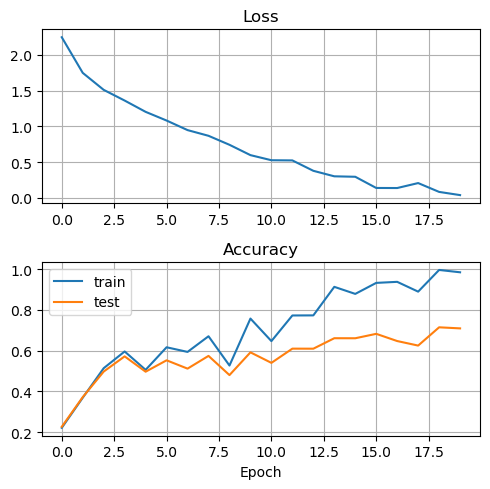

In [184]:
visualize(losses, acc_scores, "Resnet")

In [ ]:
-np.log(0.1)

Training in class incremental setting:

In [319]:
def train_class_incremental(model, optimizer, criterion, num_tasks, num_epochs_per_task=10):
    acc_on_task_0 = torch.empty(num_tasks)
    acc_on_last_task = torch.empty(num_tasks)
    
    for i in range(num_tasks):
        _, acc = train(model, optimizer, criterion, train_loaders[i], val_loaders[i], num_epochs_per_task)

        acc_on_last_task[i] = acc[1][-1]
        acc_on_task_0[i] = evaluate(model, val_loaders[0])

        print("Task ", i)
        print("Accuracy on task ", i, ": ", acc_on_last_task[i])
        print("Accuracy on task ", 0, ": ",acc_on_task_0[i])
        
    return acc_on_last_task, acc_on_task_0

In [186]:
acc_last, acc_0 = train_class_incremental(model, optimizers[0], loss_fn, num_tasks, num_epochs_per_task=10)

100%|██████████| 10/10 [01:37<00:00,  9.80s/it]


Task  0
Accuracy on task  0 :  tensor(0.7018)
Accuracy on task  0 :  tensor(0.7064)


100%|██████████| 10/10 [01:40<00:00, 10.04s/it]


Task  1
Accuracy on task  1 :  tensor(0.4910)
Accuracy on task  0 :  tensor(0.)


100%|██████████| 10/10 [01:36<00:00,  9.69s/it]


Task  2
Accuracy on task  2 :  tensor(0.5779)
Accuracy on task  0 :  tensor(0.)


100%|██████████| 10/10 [01:36<00:00,  9.63s/it]


Task  3
Accuracy on task  3 :  tensor(0.6080)
Accuracy on task  0 :  tensor(0.)


100%|██████████| 10/10 [01:32<00:00,  9.25s/it]


Task  4
Accuracy on task  4 :  tensor(0.6732)
Accuracy on task  0 :  tensor(0.)


100%|██████████| 10/10 [01:35<00:00,  9.54s/it]


Task  5
Accuracy on task  5 :  tensor(0.6879)
Accuracy on task  0 :  tensor(0.)


100%|██████████| 10/10 [01:39<00:00, 10.00s/it]


Task  6
Accuracy on task  6 :  tensor(0.6711)
Accuracy on task  0 :  tensor(0.)


100%|██████████| 10/10 [01:36<00:00,  9.67s/it]


Task  7
Accuracy on task  7 :  tensor(0.6711)
Accuracy on task  0 :  tensor(0.)


100%|██████████| 10/10 [01:42<00:00, 10.29s/it]


Task  8
Accuracy on task  8 :  tensor(0.6846)
Accuracy on task  0 :  tensor(0.)


100%|██████████| 10/10 [01:35<00:00,  9.51s/it]


Task  9
Accuracy on task  9 :  tensor(0.7404)
Accuracy on task  0 :  tensor(0.)


TODO: heatmap (acc on task - task elapsed)

In [189]:
def visualize_class_incremental(acc_last, acc_0, filename=""):
    plt.figure(figsize=(5,3))
    plt.plot(range(1, len(acc_last)+1), acc_last, label="last task")
    plt.plot(range(1, len(acc_0)+1), acc_0, label="task 0")
    plt.xlabel("Task number")
    plt.title("Test accuracy")
    plt.legend()
    plt.show()
    plt.savefig("plots/class_incremental_" + filename)

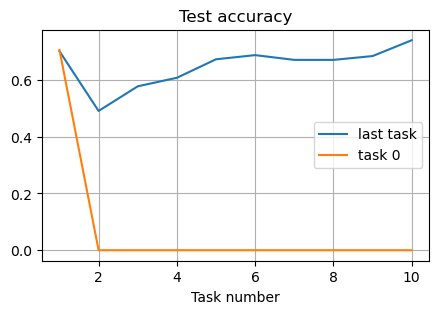

<Figure size 640x480 with 0 Axes>

In [190]:
visualize_class_incremental(acc_last, acc_0)

In [200]:
model_2 = nn.Sequential(models.vit_b_16(),
                      nn.ReLU(), 
                      nn.Linear(1000, 100),
                      nn.LogSoftmax(dim=1)
                      )
model_2.to(device)

input_shape = (1, 3, 224, 224)
summary(model_2, input_size=input_shape)

Layer (type:depth-idx)                             Output Shape              Param #
Sequential                                         [1, 100]                  --
├─VisionTransformer: 1-1                           [1, 1000]                 768
│    └─Conv2d: 2-1                                 [1, 768, 14, 14]          590,592
│    └─Encoder: 2-2                                [1, 197, 768]             151,296
│    │    └─Dropout: 3-1                           [1, 197, 768]             --
│    │    └─Sequential: 3-2                        [1, 197, 768]             85,054,464
│    │    └─LayerNorm: 3-3                         [1, 197, 768]             1,536
│    └─Sequential: 2-3                             [1, 1000]                 --
│    │    └─Linear: 3-4                            [1, 1000]                 769,000
├─ReLU: 1-2                                        [1, 1000]                 --
├─Linear: 1-3                                      [1, 100]                  100,100
├─L

In [201]:
optimizers[1] = optim.SGD(model_2.parameters(), lr=1e-2, momentum=0.9)

100%|██████████| 20/20 [10:23<00:00, 31.17s/it]


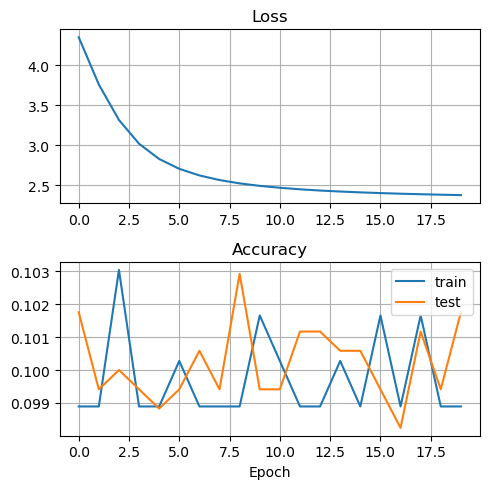

In [202]:
loss, acc = train(model_2, optimizers[1], loss_fn, train_loaders[0], test_loaders[0], num_epochs=20)
visualize(loss, acc, "vit")

In [203]:
acc_last, acc_0 = train_class_incremental(model_2, optimizers[1], loss_fn, num_tasks, num_epochs_per_task=5)

100%|██████████| 5/5 [02:36<00:00, 31.23s/it]


Task  0
Accuracy on task  0 :  tensor(0.1006)
Accuracy on task  0 :  tensor(0.0982)


100%|██████████| 5/5 [02:35<00:00, 31.20s/it]


Task  1
Accuracy on task  1 :  tensor(0.1000)
Accuracy on task  0 :  tensor(0.)


100%|██████████| 5/5 [02:36<00:00, 31.24s/it]


Task  2
Accuracy on task  2 :  tensor(0.0994)
Accuracy on task  0 :  tensor(0.)


100%|██████████| 5/5 [02:36<00:00, 31.38s/it]


Task  3
Accuracy on task  3 :  tensor(0.0994)
Accuracy on task  0 :  tensor(0.)


100%|██████████| 5/5 [02:36<00:00, 31.26s/it]


Task  4
Accuracy on task  4 :  tensor(0.1006)
Accuracy on task  0 :  tensor(0.)


100%|██████████| 5/5 [02:36<00:00, 31.23s/it]


Task  5
Accuracy on task  5 :  tensor(0.1023)
Accuracy on task  0 :  tensor(0.)


 80%|████████  | 4/5 [02:11<00:32, 32.89s/it]


KeyboardInterrupt: 

In [ ]:
visualize_class_incremental(acc_last, acc_0)

In [328]:
class MyModel(nn.Module):
    def __init__(self, backbone):
        super(MyModel, self).__init__()
        self.backbone = backbone
        self.name = type(backbone).__name__
        
        self.top_layers = nn.Sequential(nn.ReLU(), 
                                        nn.Linear(1000, 100),
                                        nn.LogSoftmax(dim=1))
    
    def forward(self, x):
        x = self.backbone(x)
        x = self.top_layers(x)
        return x


class ExperimentTrainer():
    def __init__(self, model, optimizer, loss_fn):
        self.model = model
        self.optimizer = optimizer
        self.criterion = loss_fn

        self.acc_full = [[] * num_tasks]
        self.acc_last = []
        self.acc_0 = []

    def train_full(self, task_id=0, num_epochs=20):
        loss, acc_train, acc_val = train(self.model, self.optimizer, self.criterion, 
                          train_loaders[task_id], val_loaders[task_id], num_epochs)
        self.acc_full[task_id] = acc_val
        print("Accuracy on task", task_id, ": ", acc_val[-1])
        visualize(loss, (acc_train, acc_val), filename="_".join(["task", str(task_id), self.model.name, str(num_epochs), "ep"]))
        

    def train_class_inc(self, num_tasks, num_epochs_per_task=10):
        acc_last, acc_0 = train_class_incremental(self.model, self.optimizer, 
                                                    self.criterion, num_tasks, 
                                                    num_epochs_per_task)
        self.acc_last = acc_last
        self.acc_0 = acc_0
        visualize_class_incremental(self.acc_last, self.acc_0, 
                                    filename="_".join(["CIL", str(num_tasks), self.model.name, str(num_epochs_per_task), "ep"])
                                   )


In [322]:
summary(MyModel(models.resnet50()), image_shape)

Layer (type:depth-idx)                        Output Shape              Param #
MyModel                                       [1, 100]                  --
├─ResNet: 1-1                                 [1, 1000]                 --
│    └─Conv2d: 2-1                            [1, 64, 112, 112]         9,408
│    └─BatchNorm2d: 2-2                       [1, 64, 112, 112]         128
│    └─ReLU: 2-3                              [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                         [1, 64, 56, 56]           --
│    └─Sequential: 2-5                        [1, 256, 56, 56]          --
│    │    └─Bottleneck: 3-1                   [1, 256, 56, 56]          75,008
│    │    └─Bottleneck: 3-2                   [1, 256, 56, 56]          70,400
│    │    └─Bottleneck: 3-3                   [1, 256, 56, 56]          70,400
│    └─Sequential: 2-6                        [1, 512, 28, 28]          --
│    │    └─Bottleneck: 3-4                   [1, 512, 28, 28]          379,392

In [323]:
def create_model():
    return MyModel(models.resnet50())

In [329]:
mymodel = create_model()
trainer = ExperimentTrainer(mymodel.to(device), 
                            optim.Adam(mymodel.parameters()),
                            nn.NLLLoss())

In [ ]:
trainer.train_full(task_id=0, num_epochs=50)

  2%|▏         | 1/50 [00:13<10:58, 13.44s/it]

In [326]:
trainer.acc_full

[tensor([[0.1634, 0.2313, 0.2319, 0.2723, 0.3143, 0.1668, 0.3477, 0.4427, 0.4333,
          0.5040, 0.4978, 0.5107, 0.5627, 0.5985, 0.6228, 0.6712, 0.6696, 0.5402,
          0.4928, 0.6541, 0.6955, 0.7653, 0.7273, 0.7315, 0.7880, 0.7329, 0.6551,
          0.8438, 0.8758, 0.9168, 0.9144, 0.9220, 0.9232, 0.9057, 0.8059, 0.9228,
          0.9343, 0.9602, 0.9345, 0.9252, 0.9658, 0.9510, 0.9811, 0.9813, 0.9530,
          0.9709, 0.9819, 0.9837, 0.9881, 0.9713],
         [0.1624, 0.2411, 0.2351, 0.2869, 0.3357, 0.1821, 0.3355, 0.4239, 0.4157,
          0.4889, 0.4845, 0.4974, 0.5526, 0.5876, 0.5983, 0.6124, 0.5937, 0.4880,
          0.4884, 0.5560, 0.6481, 0.6722, 0.6078, 0.6324, 0.6522, 0.6261, 0.5144,
          0.6455, 0.6636, 0.6666, 0.6768, 0.6760, 0.6493, 0.6689, 0.6122, 0.6872,
          0.6864, 0.6920, 0.6677, 0.6656, 0.6860, 0.6945, 0.7055, 0.7001, 0.7024,
          0.7068, 0.7101, 0.6953, 0.7256, 0.7129]])]